This notebook covers from Example 1 to Example 3

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sc_stats
import matplotlib.pyplot as plt


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})


In [3]:
filename = "02-table-01-vcr-data.ods"

df = pd.read_excel(filename, engine="odf", header=0, 
                   usecols=("Time", "Original Data"))

df = df.rename(columns={"Time": "t", "Original Data": "Y_t"})
df

,t,Y_t
0,1,123
1,2,130
2,3,125
3,4,138
4,5,145
5,6,142
6,7,141
7,8,146
8,9,147
9,10,157


In [4]:
# adding more columns
df_full = df.copy()
df_full["Y_tM1"] = df_full["Y_t"].shift(1)

mean_Y_t = df_full["Y_t"].mean()
df_full["Y_t - mean_Y_t"] = df_full["Y_t"] - mean_Y_t
df_full["Y_tM1 - mean_Y_t"] = df_full["Y_tM1"] - mean_Y_t
df_full["(Y_t - mean_Y_t)^2"] = df_full["Y_t - mean_Y_t"]**2
df_full["(Y_t - mean_Y_t)(Y_tM1 - mean_Y_t)"] = df_full["Y_t - mean_Y_t"] * df_full["Y_tM1 - mean_Y_t"]

r_1 = df_full["(Y_t - mean_Y_t)(Y_tM1 - mean_Y_t)"].sum() / df_full["(Y_t - mean_Y_t)^2"].sum()

print(f"mean_Y_t = {mean_Y_t}")
print(f"r_1 = {r_1:.3f}")

df_full

mean_Y_t = 142.0
r_1 = 0.572


,t,Y_t,Y_tM1,Y_t - mean_Y_t,Y_tM1 - mean_Y_t,(Y_t - mean_Y_t)^2,(Y_t - mean_Y_t)(Y_tM1 - mean_Y_t)
0,1,123,NaN,-19.0,NaN,361.0,NaN
1,2,130,123.0,-12.0,-19.0,144.0,228.0
2,3,125,130.0,-17.0,-12.0,289.0,204.0
3,4,138,125.0,-4.0,-17.0,16.0,68.0
4,5,145,138.0,3.0,-4.0,9.0,-12.0
5,6,142,145.0,0.0,3.0,0.0,0.0
6,7,141,142.0,-1.0,0.0,1.0,-0.0
7,8,146,141.0,4.0,-1.0,16.0,-4.0
8,9,147,146.0,5.0,4.0,25.0,20.0
9,10,157,147.0,15.0,5.0,225.0,75.0


## A function to compute autocorrelation

In [5]:
def autocorr(dataframe, lag, verbose=None):
  df = dataframe.copy()
  label_lag = f"Y_tM{lag}"
  df[label_lag] = df["Y_t"].shift(lag)

  mean_Y_t = df["Y_t"].mean()
  df["Y_t - mean_Y_t"] = df["Y_t"] - mean_Y_t
  df[f"{label_lag} - mean_Y_t"] = df[label_lag] - mean_Y_t
  df["(Y_t - mean_Y_t)^2"] = df["Y_t - mean_Y_t"]**2
  df[f"(Y_t - mean_Y_t)({label_lag} - mean_Y_t)"] = df["Y_t - mean_Y_t"] * df[f"{label_lag} - mean_Y_t"]

  r_lag = df[f"(Y_t - mean_Y_t)({label_lag} - mean_Y_t)"].sum() / df["(Y_t - mean_Y_t)^2"].sum()

  if verbose is not None:
    print(f"mean_Y_t = {mean_Y_t}")
    print(f"r_{lag} = {r_lag:.3f}")

  return df, r_lag


In [6]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


In [7]:
lag = 1
_, r_1 = autocorr(df, 1)
print(f"r_{lag} = {r_1:.3f}")

lag = 2
_, r_2 = autocorr(df, 2)
print(f"r_{lag} = {r_2:.3f}")


r_1 = 0.572
r_2 = 0.463


In [8]:
SE_r_1 = std_error([r_1], 1, 12)
print(f"SE_r_1 = {SE_r_1:.3f}")

SE_r_2 = std_error([r_1, r_2], 2, 12)
print(f"SE_r_2 = {SE_r_2:.3f}")

SE_r_1 = 0.289
SE_r_2 = 0.371


In [9]:
def t_test_bound(significance_lvl, num_of_samples):
  dof = num_of_samples - 1  # degree of freedom (n - 1)

  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)

  return l_bound, u_bound

def t_test_rnd_var(r_lag, SE_r_lag):
  return r_lag/SE_r_lag


In [10]:
significance_lvl = 0.05   # two-sided
num_of_samples = len(df_full.index)
l_bound, u_bound = t_test_bound(significance_lvl, num_of_samples)
r_1_t_test = t_test_rnd_var(r_1, SE_r_1)
r_2_t_test = t_test_rnd_var(r_2, SE_r_2)

print(f"[l_bound, u_bound] = {l_bound:.1f}, {u_bound:.1f}")
print(f"[r_1] t_test = {r_1_t_test:.2f}")
print(f"[r_2] t_test = {r_2_t_test:.2f}")



[l_bound, u_bound] = -2.2, 2.2
[r_1] t_test = 1.98
[r_2] t_test = 1.25


In [11]:
def print_limit_time_lags(significance_lvl, lag, SE_r_lag, l_bound):
  print(f"lag {lag}: 0 +/- t_{significance_lvl/2:.3f} SE(r_{lag})")
  print(f"  0 +/- {np.abs(l_bound):.1f}({SE_r_lag:.3f})")
  print(f"  ({-np.abs(l_bound)*SE_r_lag:.3f}, {np.abs(l_bound)*SE_r_lag:.3f})")

In [12]:
print_limit_time_lags(significance_lvl, 1, SE_r_1, l_bound)
print_limit_time_lags(significance_lvl, 2, SE_r_2, l_bound)

lag 1: 0 +/- t_0.025 SE(r_1)
  0 +/- 2.2(0.289)
  (-0.635, 0.635)
lag 2: 0 +/- t_0.025 SE(r_2)
  0 +/- 2.2(0.371)
  (-0.817, 0.817)


## Ljung-Box $Q$

Example 3

In [13]:
filename = "02-table-03-time-series-40randomNums.ods"

df_random_num = pd.read_excel(filename, engine="odf", header=0, usecols=("t", "Yt"))
df_random_num = df_random_num.rename(columns={"Yt": "Y_t"})
df_random_num.head()


,t,Y_t
0,1,343
1,2,574
2,3,879
3,4,728
4,5,37


In [14]:
lag = 1
_, r_1 = autocorr(df_random_num, 1)
print(f"r_{lag} = {r_1:.3f}")

lag = 2
_, r_2 = autocorr(df_random_num, 2)
print(f"r_{lag} = {r_2:.3f}")


r_1 = -0.191
r_2 = -0.006


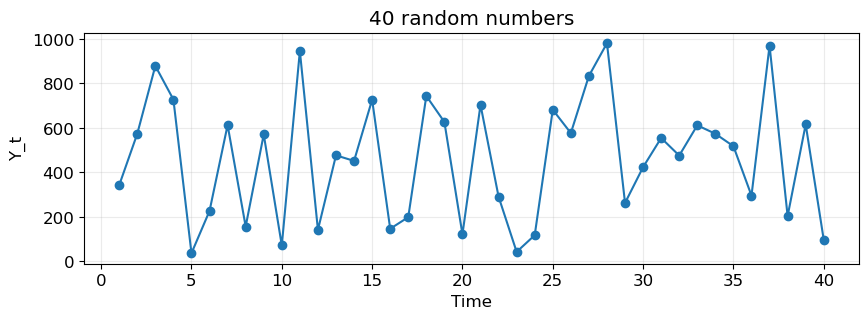

In [16]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(df_random_num["t"], df_random_num["Y_t"], marker='o')
ax.set_xlabel("Time")
ax.set_ylabel("Y_t")
ax.set_title("40 random numbers")
ax.grid("on")
plt.show(fig)

In [16]:
# From https://stackoverflow.com/q/30399534
def shift_numpy(arr, num, fill_value=np.NaN):
  result = np.empty_like(arr, dtype=float)
  if num > 0:
    result[:num] = fill_value
    result[num:] = arr[:-num]
  elif num < 0:
    result[num:] = fill_value
    result[:num] = arr[-num:]
  else:
    result[:] = arr
  return result

In [17]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

In [18]:
df_acorr_analysis = get_correlogram(df_random_num, 10, columns=['t', "Y_t"])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,-0.191171,-1.209074,1.574310,-0.319816,0.319816
1,2,-0.006293,-0.038420,1.576061,-0.331298,0.331298
2,3,-0.145224,-0.886609,2.533655,-0.331310,0.331310
3,4,0.104475,0.625657,3.043023,-0.337758,0.337758
4,5,-0.253756,-1.504979,6.133832,-0.341047,0.341047
5,6,0.028640,0.160985,6.174361,-0.359841,0.359841
6,7,0.169071,0.949746,7.629602,-0.360074,0.360074
7,8,-0.027390,-0.150504,7.668988,-0.368104,0.368104
8,9,-0.032551,-0.178765,7.726412,-0.368313,0.368313
9,10,0.021546,0.118232,7.752409,-0.368607,0.368607


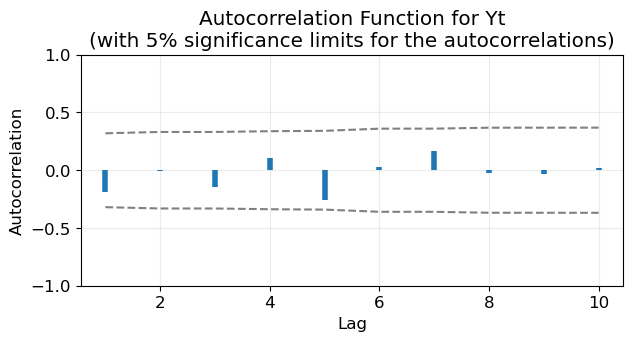

In [19]:
fig, ax = plt.subplots(figsize=(7, 3))

lag_arr = df_acorr_analysis["k"].to_numpy()
stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

# [0] = markerline handler
# [1] = stemlines handler
# [2] = baseline handler
stem_handler[0].set_marker(None)
stem_handler[1].set_linewidth(4)
stem_handler[2].set_alpha(0)

ax.grid("on")
ax.set_ylim([-1, 1])
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function for Yt\n"
  + "(with 5% significance limits for the autocorrelations)")

plt.show(fig)

If there is no autocorrelation at any lag, the $Q$ statistic has a chi-square distribution with, in this case, `dof = 10`.   
Consequently, a large value for $Q$ (in the tail of the chi-square distribution) is evidence against the null hypothesis.

In [20]:
dof = 10        # degree of freedom (number of lags under consideration)
significance_lvl = 0.05
u_bound = sc_stats.chi2.ppf(1-significance_lvl, df=dof)
print(f"u_bound = {u_bound:.2f}")

u_bound = 18.31
